In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### 2-D SPH Toy Model
ZERO = np.array([0., 0., 0.])
DENS = 600
MASS = 0.18
GRAV = np.array([0., -9.8, 0.])
KSTIFF = .3
PFAC = 7.0
THRESHOLDSQR = 7
SURFTENS = 0.05
VISC = .03

In [3]:
class Particle:
    def __init__(self, loc= np.array([0., 0., 0.]), vel=np.array([0., 0., 0.]), col=1):
        self.loc = loc
        self.vel = vel
        self.acc =  np.array([0., 0., 0.])
        self.force =  np.array([0., 0., 0.])
        self.color = col
        self.before_vel, self.after_vel =  vel,  np.array([0., 0., 0.])
        
        self.neighbors = []
        self.dens = DENS
        self.mass = MASS
        self.pressure = 101325
        
    def move(self, tstep):
        pass

In [4]:
def wpoly6(r,h):
    coeff = 315/(64*np.pi*h**9)
    mag = np.sqrt(np.dot(r,r))
    if mag > h:
        return 0.0
    
    return coeff * (h**2 - mag**2)**3

def dpoly6(r,h):
    coeff = -945/(32*np.pi*h**9)
    mag = np.sqrt(np.dot(r,r))
    if mag > h:
        return np.array([0., 0., 0.])
    
    return coeff * r * (h**2 - mag**2)**2

def ddpoly6(r, h):
    rmagsq = np.dot(r,r)
    hsqr = h*h
    coeff = -945/(32*np.pi*h**9)
    if rmagsq <= hsqr:
        return coeff * (hsqr - rmagsq)*(3*hsqr - 7*rmagsq)
    else:
        return 0.0
    
def viscoKernel(r, h):
    rmag = np.sqrt(np.dot(r,r))
    coeff = 45/(np.pi*h**6)
    if rmag <=h:
        return (h-rmag)*coeff
    else:
        return 0.0
    
def densityKernel(r,h):
    rmagsq = np.dot(r,r)
    hsqr = h**2
    coeff = 315/(64*np.pi*h**9)
    if rmagsq <= hsqr:
        return coeff * (hsqr-rmagsq)**3
    else:
        return 0.0
    
def pressureKernel(r,h):
    coeff = -45/(np.pi*h**6)
    rmag = np.sqrt(np.dot(r,r))
    if rmag <= h:
        return r * coeff * (h-rmag)**2 * (1.0/rmag)
    else:
        return np.array([0., 0., 0.])

In [5]:
class SPH:
    BOXWIDTH = 3.0
    TSTEP = 0.003
    def __init__(self, num_part=529, num_steps=1000, H=0.15):
        self.RIGHTWALL = 3
        self.H = H
        self.N = num_part
        self.particles = []#np.array([Particle() for i in range(num_part)])
        self.num_steps = num_steps
        self.spaces = {}
    
    def dam_break(self):
        self.particles = []
        for i in range(350):
            x = random.uniform(0,1)
            y = random.uniform(0,3)
            self.particles.append(Particle(np.array([x,y,0.])))
            
    def moving_plate(self):
        self.particles = []
        for i in range(350):
            x = random.uniform(0,3)
            y = random.uniform(0,2)
            self.particles.append(Particle(np.array([x,y,0.])))
            
        for xcord in np.linspace(-1, 4, 50):
            self.particles.append(Particle(np.array([xcord, 0., 0.,]), np.array([0.1, 0., 0.]), -1))
            self.particles.append(Particle(np.array([xcord, -self.H, 0.,]), np.array([0.1, 0., 0.]), -1))
    
    def find_neighbors(self):
        self.spaces = {}
        for i,p in enumerate(self.particles):
            x = int(np.floor(p.loc[0]/self.H))
            y = int(np.floor(p.loc[1]/self.H))
            key = str(x)+'x,' + str(y)
            self.spaces[key] = self.spaces.get(key, []) + [i]
            p.neighbors = []
            
        for i,p in enumerate(self.particles):
            x = int(np.floor(p.loc[0]/self.H))
            y = int(np.floor(p.loc[1]/self.H))
            key = str(x)+'x,' + str(y)
            p.neighbors = [n for n in self.spaces[key] if n != i]
            
            neighboring_cells = [str(x+1)+'x,' + str(y-1),str(x+1)+'x,' + str(y),str(x+1)+'x,' + str(y+1),
                                str(x)+'x,' + str(y+1),str(x)+'x,' + str(y-1),
                                str(x-1)+'x,' + str(y-1),str(x-1)+'x,' + str(y),str(x-1)+'x,' + str(y+1)]
            for ky in neighboring_cells:
                p.neighbors += self.spaces.get(ky, [])
    
    
    def calc_density_pressure(self):
        for i,p in enumerate(self.particles):
            density, pressure = 0.,0.
            for j in p.neighbors:
                r_ = p.loc - self.particles[j].loc
                density += self.particles[j].mass*densityKernel(r_, self.H)
            density += p.mass*densityKernel(0, self.H)
            p.dens = density
            #p.pressure = KSTIFF * ((density/DENS)**PFAC - 1)
            p.pressure = KSTIFF *(p.dens - DENS)
    
    def calc_forces(self):
        for i,p in enumerate(self.particles):
            pressure_force = np.array([0.,0., 0.])
            visco_force = np.array([0.,0., 0.])
            surface_force = np.array([0.,0., 0.])
            surface_forcedn = 0.
            for j in p.neighbors:
                p2 = self.particles[j]
                r_ = p.loc - p2.loc
                pressure_force -= (p.dens + p2.dens)/(p.dens**2 + p.dens**2)*pressureKernel(r_,self.H)
                visco_force += VISC*(p2.vel - p.vel) * p2.mass/p2.dens * viscoKernel(r_, self.H)
                surface_force += (p2.mass/p2.dens) * dpoly6(r_, self.H)
                surface_forcedn += ddpoly6(r_, self.H) * p2.mass/p2.dens
                
            
            surface1 = np.sqrt(np.dot(surface_force,surface_force))
            if surface1 >= THRESHOLDSQR:
                surface_force = surface_force * SURFTENS * (-surface_forcedn/np.sqrt(surface1))
            else:
                surface_foce = 0
            p.force = p.mass*GRAV + pressure_force + visco_force + surface_force
            p.acc = (1/p.mass)*p.force
    
    def integrate(self):
        for i,p in enumerate(self.particles):
            if p.color == -1:
                p.acc = np.array([0.,0.,0.])
                
            p.after_vel = p.before_vel + SPH.TSTEP*p.acc
            p.vel = 0.5 * (p.before_vel + p.after_vel)
            p.before_vel = p.after_vel
            p.loc += p.after_vel*SPH.TSTEP
            
            if p.color == -1:
                if p.loc[0] >= 4:# SPH.BOXWIDTH*1.2:
                    p.loc[0] -= 5#SPH.BOXWIDTH*1.2
                continue
            
            if p.loc[1] <= 0:
                if p.after_vel[1] < 0:
                    p.after_vel[1] *= -0.8
                    p.after_vel[0] *= 0.8
                p.vel = p.after_vel;
                p.before_vel = p.after_vel
                p.loc[1] = -p.loc[1]
            ''' 
            if p.loc[1] >= SPH.BOXWIDTH:
                if p.after_vel[1] > 0:
                    p.after_vel[1] *= -0.8
                    p.after_vel[0] *= 0.8
                p.vel = p.after_vel;
                p.before_vel = p.after_vel
                p.loc[1] = 0.95*SPH.BOXWIDTH
             '''   
            if p.loc[0] <= 0:
                '''
                if p.after_vel[0] < 0:
                    p.after_vel[0] *= -0.8
                    p.after_vel[1] *= 0.8
                p.vel = p.after_vel;
                p.before_vel = p.after_vel
                p.loc[0] = -p.loc[0]
                '''
                p.loc[0] += self.RIGHTWALL
                
            if p.loc[0] >= self.RIGHTWALL:
                '''
                if p.after_vel[0] > 0:
                    p.after_vel[0] *= -0.8
                    p.after_vel[1] *= 0.8
                p.vel = p.after_vel;
                p.before_vel = p.after_vel
                p.loc[0] =self.RIGHTWALL - (p.loc[0] - self.RIGHTWALL)
                '''
                p.loc[0] -= self.RIGHTWALL;
            
    def simulate(self):
        self.find_neighbors()
        self.calc_density_pressure()
        self.calc_forces()
        self.integrate()
        
    def plot_frame(self):
        X = np.array([p.loc[0] for p in self.particles])
        Y = np.array([p.loc[1] for p in self.particles])
        
        fig, ax = plt.subplots(figsize=(7,7))
        ax.plot(X, Y, 'o')
        ax.set_xlim(0, SPH.BOXWIDTH)
        ax.set_ylim(0, SPH.BOXWIDTH)
        
    def get_xy(self):
        X = np.array([p.loc[0] for p in self.particles])
        Y = np.array([p.loc[1] for p in self.particles])
        return X, Y

In [6]:
import datetime

In [7]:
from matplotlib import animation

In [8]:
SIM = SPH()
SIM.moving_plate()

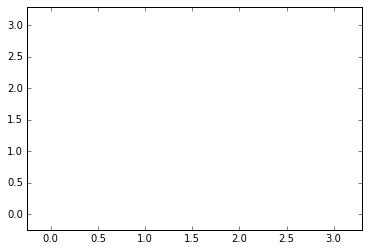

In [9]:
fig, ax = plt.subplots()
ax.set_xlim(-0.25, 1.1*SPH.BOXWIDTH)
ax.set_ylim(-0.25, 1.1*SPH.BOXWIDTH)
line, = ax.plot([],[], 'bo')
line2, = ax.plot([],[],'ko')
tm = 0
def init():
    line.set_data([],[])
    line2.set_data([],[])
    return line,line2

def animate(i):
    SIM.simulate()
    if i % 100 == 0:
        print(i)
    
    
    X,Y = SIM.get_xy()
    X = np.array([p.loc[0] for p in SIM.particles if p.color == 1])
    Y = np.array([p.loc[1] for p in SIM.particles if p.color == 1])
    line.set_data(X,Y)
    X2 = np.array([p.loc[0] for p in SIM.particles if p.color == -1])
    Y2 = np.array([p.loc[1] for p in SIM.particles if p.color == -1])
    line2.set_data(X2,Y2)
    return line,line2

In [10]:
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=1200, interval=100, blit=True)

In [11]:
begin = datetime.datetime.now()
anim.save('sph_2017-plate.mp4', fps=50, extra_args=['-vcodec', 'libx264'])
end = datetime.datetime.now()

0
100
200
300
400
500
600
700
800
900
1000
1100


In [ ]:
%timeit SIM.simulate()

In [ ]:
(end - begin)

In [ ]:
SIM.particles[-1].color

In [ ]:
begin

In [ ]:
165/60

In [ ]:
SIM.particles[-1].vel

In [ ]:
for p in SIM.particles:
    if p.color == -1:
        p.vel[0] = 0.1;

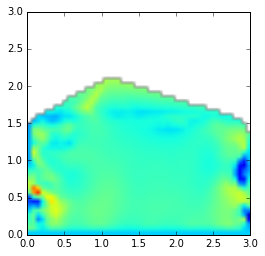

In [13]:
import scipy.interpolate

x,y,z = [a.loc[0] for a in SIM.particles], [a.loc[1] for a in SIM.particles], [a.vel[0] for a in SIM.particles]
xi, yi = np.linspace(0, 3),np.linspace(0, 3)
xi, yi = np.meshgrid(xi,yi)
zi = scipy.interpolate.griddata((x,y),z,(xi,yi), method='linear')

plt.imshow(zi, vmin=min(z), vmax=max(z), origin='lower',
           extent=[0, 3, 0, 3])

(0, 3)

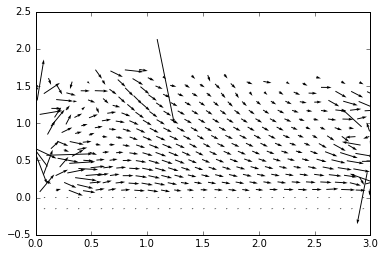

In [16]:
X, Y = [a.loc[0] for a in SIM.particles], [a.loc[1] for a in SIM.particles]
U, V = [a.vel[0] for a in SIM.particles], [a.vel[1] for a in SIM.particles]
xi, yi = np.linspace(0, 3),np.linspace(0, 3)
xi, yi = np.meshgrid(xi,yi)

plt.quiver(X, Y, U, V)
plt.xlim(0,3)